In [2]:
%load_ext autoreload
%autoreload 2

from sys import getsizeof
import os
import re
import pickle
import sqlite3
import matplotlib.pyplot as plt

import seaborn as sns
import gc
import warnings

from matplotlib import colors
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import math


from scipy.stats import skewnorm, norm
from scipy.special import comb


from RnnNoiseKim import CustomRnnStruct,SettingsDict


import pickle
import scipy.io

from torch.utils.tensorboard import SummaryWriter
from io import BytesIO
import PIL.Image


from collections import Counter 
import itertools
import locale
import datetime
# Set the locale to Japanese
locale.setlocale(locale.LC_TIME, 'ja_JP')

'ja_JP'

In [3]:
settings = SettingsDict({
    "PrintSettings": False,
    "Pips":20, "T":200, "Tdelay":0, "Blocks":2**12, "BlockLength":4, "stim_on":50, "stim_dur":60, "stim_delay":10,
    "BioConstraints":False,"Clamping":True,
    "layerNorm":False,
    "LR_Scheduler":"NoLR" ,"factor":0.5,"patience":10,"min_lr":0.0001,  
    "Wr_Dropout":False,"tauS_Dropout":False,"Wout_Dropout":False,"bout_Dropout":False,"pDropout":0.1,
    "Delay_Type":"Fixed","Delays":[0,200,400,600], "DelayProbs":[0.25, 0.25, 0.25, 0.25],  
    "FitSessions":10, "num_epochs":100,
    "SampleTrain":"Uniform", "accum_steps":1, "batch_size":2**6, "Loss":"MSE", "lr":0.001, "betas":(0.9, 0.999),"weight_decay":5e-4,"Regularization":"None", "lambda":0.01,"LrDips":1,"eta_min":0.1,"weight":100, 
    "catch_decision_Trian_on":True,"TrainCatchTrialOnly":False,
    "Continual":True,'Eligible Age':5, 'Replacement_Rate':10e-5, 'DecayRate':0.99,"EWC":False,"lambda_ewc":1000,
    "max_gradient_norm":10,"GradientClipping":True,"PrintGradientNorms":False,
    "Manipulation":"None",
    "SuppressLength":100, "DelaySuppressOn":False, "StimSuppressOn":False, "SuppressCatchOnly":False, "EvalCatchTrialOnly":False,  
    "Eval_Threshold":0.75, "Eval_Freq":1, "GPU_Eval_Blocks":20,"BlockMultiplier": 5, 
    "SampleTest":"Uniform", "RandCatchTest":False,"ProbArrayInput":[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    "perf":1, "catch_perf":0.95, 
    "InitEvaluate":False, "filename":"Fit","EpochSaveFreq":5,
    "Validate": True,"ValFreq":3,
    "TrainSetEval":False,
    "mu_InternalNoise":0,"sigma_InternalNoise":1,"mu_ExternalNoise":0,"sigma_ExternalNoise":0.01
})

Device Selected:  cuda


Model parameters saved to database.
c:\Users\cilli\OneDrive\Documents\RIKEN\CellSubmission\RNNmodelDB\sigmoid\RateRNNstructNUM10.db
0.78125


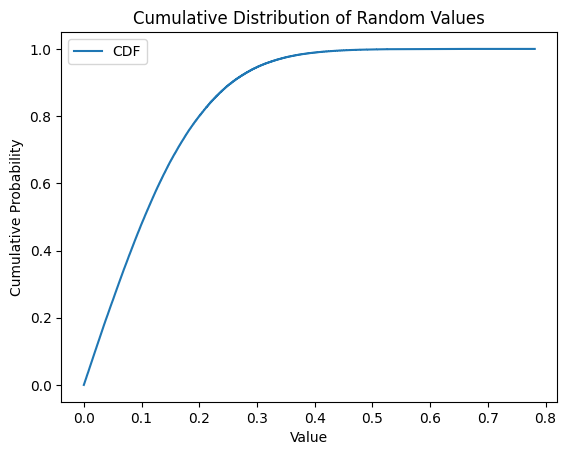

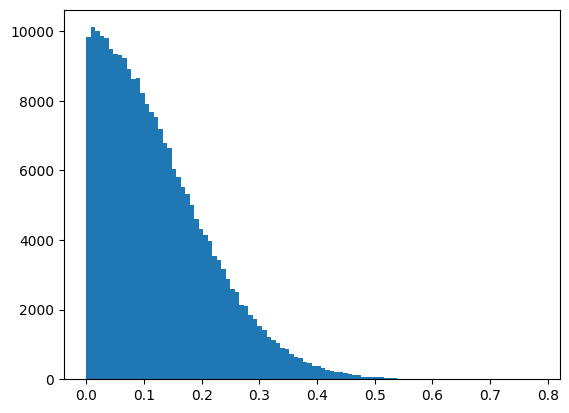

In [4]:
N = 500
apply_dale = True
prop_inh = 0.3
prop_som = 0.1
prob_rec = 1.0
Prop_PUL = 0.14
Prop_TRN = 0.06
gain = 3.5
input_size = 1
output_size = 1
noise_channels = 10
tausRange = [4, 20]
Device = "cuda"
ppc_rate = "sigmoid" #'leaky_relu' 
pul_rate = "sigmoid" #'leaky_relu', "surrogate_generalized_sigmoid"
trn_rate = "sigmoid"#'alpha_leaky_relu', "generalized_sigmoid", "sigmoid", "surrogate_sigmoid"

NewModel = True
SubModelName = "sigmoid" # "generalized_sigmoid"


db_path = None
#db_path = r'c:\\Users\\cilli\\OneDrive\\Documents\\RIKEN\\CellSubmission\\RNNmodelDB\\Test_Sigmoid\\RateRNNstructNUM0.db'
model0 = CustomRnnStruct(  N, Prop_PUL, Prop_TRN, apply_dale, prop_inh, prop_som, prob_rec, gain, input_size, output_size, noise_channels,tausRange, ppc_rate, pul_rate, trn_rate, Device, NewModel, SubModelName, db_path)
print(model0.db_path)

# Sample data
data =  model0.Wr.detach().cpu().numpy().flatten()  # 1000 random values
print(max(data))
# Sort the data
sorted_data = np.sort(data)

# Calculate the cumulative distribution (y-values range from 0 to 1)
cumulative_distribution = np.linspace(0, 1, len(sorted_data))

# Plot the cumulative distribution
plt.plot(sorted_data, cumulative_distribution, label='CDF')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Random Values')
plt.legend()

# Display the plot
plt.show()

plt.hist(data,bins=100);



### No Delay 

In [5]:
#model0.load_data(filename="Model4_ReLu")
settings["batch_size"] = 2**6 # [32, 256]
settings["Blocks"] = 2**12
settings["DelayProbs"] = [0.25, 0.25, 0.25, 0.25]
settings["num_epochs"] = 30 # Bigger Bacth Size, more Epochs
settings["FitSessions"] = 1
settings["Tdelay"] = 0
settings["Delay_Type"] = "Fixed"

settings["BioConstraints"] = False
settings["Clamping"] = False

settings["layerNorm"] = False

settings["LR_Scheduler"] = "CosineAnnealingLR" #ReduceLROnPlateau  CosineAnnealingLR
settings["factor"] = 0.9
settings["patience"] = 10
settings["min_lr"] = 0.0001

settings["betas"] = (0.9, 0.999) # (0.9, 0.999)
settings["weight_decay"] = 5e-4 # 1e-2

DipLength = 10
WholeDips = settings["num_epochs"]//DipLength

settings["LrDips"] = WholeDips + 1 if WholeDips%2 == 0  else WholeDips
settings["lr"] = 0.001
settings["eta_min"] = 0.1

settings["Loss"] = "MSE" # "MSE" "MAE" "LogCosh"
settings["accum_steps"] = 1
settings["Regularization"] = "None"
settings["lambda"] = 0.01
settings["weight"] = 1

settings["catch_perf"] = 0.96
settings["EpochSaveFreq"] = 5
settings["SampleTrain"] = "Uniform"
settings["Continual"] = False
settings["EWC"] = False
settings["lambda_ewc"] = 100
settings["max_gradient_norm"] = 10
settings["GradientClipping"] = True
settings["PrintGradientNorms"] = False

settings["SampleTest"] = "Pure"

print("LR Dips: ",settings["LrDips"])
print(settings["Blocks"])
print(settings["batch_size"])
print(settings["Blocks"]/settings["batch_size"])
print(settings["SampleTrain"])
print(settings["SampleTest"])
model0.db_path

LR Dips:  3
4096
64
64.0
Uniform
Pure


'c:\\Users\\cilli\\OneDrive\\Documents\\RIKEN\\CellSubmission\\RNNmodelDB\\sigmoid\\RateRNNstructNUM10.db'

In [5]:
model0.rate_PPC_Params["fmax"] = 1.0
model0.rate_PUL_Params["fmax"] = 1.0
model0.rate_TRN_Params["fmax"] = 1.0

model0.rate_PPC_Params["c"] = 0.0
model0.rate_PUL_Params["c"] = 0.0
model0.rate_TRN_Params["c"] = 0.0

model0.rate_PPC_Params["beta"] = 1.0
model0.rate_PUL_Params["beta"] = 1.0
model0.rate_TRN_Params["beta"] = 1.0

In [ ]:
DiscrimPerform = 0
CatchPerform = 0
settings["Tdelay"] = 0

counter = 0
while (DiscrimPerform <= 1 and CatchPerform < 0.95) and counter <= 3:
    EvalOutput,BreakFlag = model0.train_model(settings)
    DiscrimPerform = EvalOutput["eval_perf_discrim_mean"]
    CatchPerform = EvalOutput["eval_perf_catch_mean"]
    counter += 1

-------------Initial Fit Model-------------------------------


In [10]:
EvalOutput = model0.EvalModel(settings,True,[])

No Manipulation Occurs


2025.05.13 - 16:22   Total Performance: 0.470   Discrimination Performance: 0.477   Catch Performance: 0.450
Discrimination Left Performance: 0.000   Discrimination Right Performance: 1.000
Catch Left Performance: 0.000   Catch Right Performance: 1.000


In [14]:
EvalOutput["rEvals"][0]

tensor([[[0.4994, 0.8933, 0.9668,  ..., 1.0000, 1.0000, 1.0000],
         [0.5003, 0.7204, 0.9903,  ..., 1.0000, 1.0000, 1.0000],
         [0.5000, 0.9046, 0.9862,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4999, 0.7019, 0.9525,  ..., 1.0000, 1.0000, 1.0000],
         [0.5001, 0.9370, 0.9933,  ..., 1.0000, 1.0000, 1.0000],
         [0.4996, 0.8060, 0.9890,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4997, 0.2931, 0.5196,  ..., 1.0000, 1.0000, 1.0000],
         [0.5008, 0.9129, 0.9794,  ..., 1.0000, 1.0000, 1.0000],
         [0.4999, 0.9525, 0.9956,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4997, 0.7609, 0.9891,  ..., 1.0000, 1.0000, 1.0000],
         [0.5004, 0.7095, 0.9260,  ..., 1.0000, 1.0000, 1.0000],
         [0.4996, 0.7374, 0.8314,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.5001, 0.2543, 0.5697,  ..., 1.0000, 1.0000, 1.0000],
         [0.5003, 0.6422, 0.9363,  ..., 1.0000, 1.0000, 1.0000],
         [0.5005, 0.7751, 0.9767,  ..., 1.0000, 1.0000, 1.

In [42]:
output_utility = 0

batch_size = EvalOutput["rEvals"][0].shape[0]
N = EvalOutput["rEvals"][0].shape[1]
blockSteps = EvalOutput["rEvals"][0].shape[2]
NumOfUnitsToReplace = 0

rateOutput = torch.randn(batch_size, N, blockSteps,device="cpu",requires_grad=False)
age = torch.zeros(N, blockSteps,device="cpu",requires_grad=False)

In [8]:
#continual_on = settings["Continual"]
continual_on = True
eligible_age =  settings["Eligible Age"]
replacement_rate = settings["Replacement_Rate"]
decay_rate = settings["DecayRate"]

Wr_contrib  = torch.zeros(batch_size,N,device="cpu",requires_grad=False)
Tau_contrib = torch.zeros(batch_size,N,device="cpu",requires_grad=False)

#-------------------------------------------------------------------------
# Update Age
#-------------------------------------------------------------------------
age += 1


if continual_on == True:


    if model0.apply_dale == True:
        WrDale = torch.relu(model0.Wr)
    else:
        WrDale = model0.Wr
    WrReal = torch.mul( WrDale, model0.SynapseMask).cpu(); 
    TauS = model0.tauS.cpu()
    TauS = TauS.squeeze() 
 
    with torch.no_grad():

        #-------------------------------------------------------------------------
        # Update Utility
        #-------------------------------------------------------------------------

        for b in range(0,batch_size):
            for t in range(0,blockSteps):
                Wr_contrib[b,:] += (1-decay_rate) * torch.multiply(torch.abs(rateOutput[b,:,t]),torch.sum(torch.abs(WrReal),dim = 0)) 
                Tau_contrib[b,:] +=  (1-decay_rate) * torch.multiply(torch.abs(rateOutput[b,:,t]), torch.abs( TauS ))
        
        # Average Across the Batches
        Wr_contrib_avg  = torch.mean(Wr_contrib, dim=0) 
        Tau_contrib_avg = torch.mean(Tau_contrib,dim=0)

        # Calculate Output Utility 
        output_utility = decay_rate * output_utility + (1-decay_rate)*Wr_contrib_avg + (1-decay_rate)*Tau_contrib_avg
        
        #-------------------------------------------------------------------------
        # Find eligible units: neligible = number of units with age greater than m
        #-------------------------------------------------------------------------
        eligible_units = (age > eligible_age).sum()


        NumOfUnitsToReplace = NumOfUnitsToReplace + eligible_units*replacement_rate

        if NumOfUnitsToReplace > 1:
            print("Update Neuron")
            min_utility_index = torch.argmin(output_utility)
            WrN_init = (np.random.normal(loc=0, scale=1.0, size=N))/np.sqrt(N*prob_rec)*gain
            if apply_dale == True:
                WrN = np.abs(WrN_init)

            tauSN = np.random.uniform(tausRange[0], tausRange[1],1)

            model0.tauS[min_utility_index,0] = torch.tensor(tauSN)
            model0.Wr[:,min_utility_index] = torch.tensor(WrN)
            model0.Wout[0,min_utility_index] = 0

            output_utility[min_utility_index] = 0
            age[min_utility_index] = 0
            NumOfUnitsToReplace -= 1

output_utility 

tensor([5.0940, 4.6086, 4.5191, 3.5635, 4.5456, 5.0570, 3.6971, 4.9953, 4.8066,
        4.6765, 5.2273, 3.8878, 4.9955, 4.4322, 4.1080, 5.3517, 5.0645, 4.2974,
        4.2020, 3.7920, 4.9319, 4.9654, 4.7812, 4.1951, 3.3766, 4.0426, 4.2203,
        5.0217, 4.5647, 4.2231, 4.4935, 3.9418, 4.7941, 4.3346, 4.9922, 4.7940,
        4.7502, 5.1808, 3.9239, 3.7440, 5.0506, 4.0381, 5.1980, 4.6247, 4.7823,
        4.5971, 4.3026, 3.5447, 5.1217, 3.8210, 5.1482, 4.6707, 4.3095, 4.2567,
        5.1791, 5.0560, 3.8005, 3.4979, 4.1794, 3.2938, 4.4191, 4.3484, 4.3970,
        4.3643, 3.5127, 5.4244, 3.9287, 4.2528, 3.3540, 4.7896, 4.7107, 4.3825,
        3.7336, 5.3824, 4.0631, 4.9464, 4.2328, 4.4482, 5.0168, 4.9439, 4.8507,
        4.3556, 3.7717, 5.1873, 4.3150, 4.6655, 5.3454, 5.1120, 5.2782, 4.1878,
        3.5831, 4.2271, 4.5020, 5.2907, 4.3456, 3.7822, 3.9193, 5.0758, 5.3677,
        4.8655, 3.9987, 3.3683, 4.7471, 3.4768, 5.2534, 4.2390, 4.4874, 4.9744,
        4.7109, 4.4124, 4.7141, 4.0531, 

In [ ]:
output_utility = 0
NumOfUnitsToReplace = 0
eligible_units = 0
blockSteps = EvalOutput["rEvals"][0].shape[2]
rateOutput = torch.randn(batch_size, N, blockSteps,device="cpu",requires_grad=False)
age = torch.zeros(N, 1,device="cpu",requires_grad=False)

print("output_utility: ", output_utility)
print("NumOfUnitsToReplace: ", NumOfUnitsToReplace)
print("eligible_units: ", eligible_units)
print("age: ", age)

output_utility:  tensor([250.5053, 228.1875, 223.1633, 175.1978, 223.7045, 253.2513, 182.8485,
        250.9584, 236.4771, 230.2903, 255.5215, 194.0678, 246.1915, 222.3718,
        204.7078, 262.9134, 253.1528, 212.6225, 207.8427, 190.4100, 243.9197,
        245.9459, 236.3611, 209.2178, 167.3214, 200.5384, 209.1674, 250.1466,
        225.8350, 208.0958, 223.4698, 194.4453, 237.3162, 215.4185, 247.3642,
        238.9588, 232.5802, 257.8306, 193.0713, 185.1614, 248.7165, 198.9930,
        255.9633, 231.3917, 236.8535, 226.9196, 210.8564, 173.3725, 253.2331,
        190.9597, 254.6710, 230.5508, 214.4438, 209.1517, 252.1843, 251.5552,
        186.7272, 173.0112, 206.2427, 163.2654, 219.3584, 213.5883, 218.8666,
        217.8497, 173.2043, 266.6379, 194.7566, 211.4868, 165.8429, 237.5303,
        234.4647, 215.4884, 186.4170, 262.3401, 202.3897, 245.4491, 207.5974,
        218.6643, 247.1325, 246.2166, 241.0668, 216.7561, 184.8829, 256.1494,
        214.9648, 232.0830, 261.3807, 252.6202,

In [154]:
continual_on = settings["Continual"]
continual_on = True
eligible_age =  settings["Eligible Age"]
replacement_rate = settings["Replacement_Rate"]
decay_rate = settings["DecayRate"]

batch_size = rateOutput.shape[0]
N = rateOutput.shape[1]
blockSteps = rateOutput.shape[2]


if continual_on == True:
    Wr_contrib  = torch.zeros(batch_size,N,device="cpu",requires_grad=False)
    Tau_contrib = torch.zeros(batch_size,N,device="cpu",requires_grad=False)



    if model0.apply_dale == True:
        WrDale = torch.relu(model0.Wr)
    else:
        WrDale = model0.Wr
    WrReal = torch.mul( WrDale, model0.SynapseMask).cpu(); 
    TauS = model0.tauS.cpu()
    TauS = TauS.squeeze() 

    with torch.no_grad():

        #-------------------------------------------------------------------------
        # Update Age
        #-------------------------------------------------------------------------
        
        age += 1
        #-------------------------------------------------------------------------
        # Update Utility
        #-------------------------------------------------------------------------

        rate_abs = torch.abs(rateOutput)  # [B, N, T]
        Wr_magnitude = torch.sum(torch.abs(WrReal), dim=0)  # [N]
        Tau_magnitude = torch.abs(TauS)  # [N]

        Wr_contrib = (1 - decay_rate) * torch.sum(rate_abs * Wr_magnitude[None, :, None], dim=2)
        Tau_contrib = (1 - decay_rate) * torch.sum(rate_abs * Tau_magnitude[None, :, None], dim=2)

        
        # Average Across the Batches
        Wr_contrib_avg  = torch.mean(Wr_contrib, dim=0) 
        Tau_contrib_avg = torch.mean(Tau_contrib,dim=0)

        # Calculate Output Utility 
        output_utility = decay_rate * output_utility + (1-decay_rate)*Wr_contrib_avg + (1-decay_rate)*Tau_contrib_avg
        
        #-------------------------------------------------------------------------
        # Find eligible units: neligible = number of units with age greater than m
        #-------------------------------------------------------------------------
        eligible_units = (age > eligible_age).sum()


        NumOfUnitsToReplace = NumOfUnitsToReplace + (eligible_units*replacement_rate)

        if NumOfUnitsToReplace > 1:

            min_utility_index = torch.argmin(output_utility)
            WrN_init = (np.random.normal(loc=0, scale=1.0, size=N))/np.sqrt(N*prob_rec)*gain
            if apply_dale == True:
                WrN = np.abs(WrN_init)

            tauSN = np.random.uniform(tausRange[0], tausRange[1],1)

            model0.tauS[min_utility_index,0] = torch.tensor(tauSN)
            model0.Wr[:,min_utility_index] = torch.tensor(WrN)
            model0.Wout[0,min_utility_index] = 0

            output_utility[min_utility_index] = 0
            age[min_utility_index] = 0
            NumOfUnitsToReplace -= 1

#print("output_utility: ", output_utility)
print("NumOfUnitsToReplace: ", NumOfUnitsToReplace)
print("eligible_units: ", eligible_units)
print("age: ", age)

NumOfUnitsToReplace:  tensor(0.4995)
eligible_units:  tensor(500)
age:  tensor([[35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.],
        [35.]

In [143]:
age > eligible_age
(age > eligible_age).sum()


tensor(499)

In [114]:
output_utility = 0

batch_size = EvalOutput["rEvals"][0].shape[0]
N = EvalOutput["rEvals"][0].shape[1]
blockSteps = EvalOutput["rEvals"][0].shape[2]
NumOfUnitsToReplace = 0

rateOutput = torch.randn(batch_size, N, blockSteps,device="cpu",requires_grad=False)
age = torch.zeros(N, blockSteps,device="cpu",requires_grad=False)

In [179]:
def reinitNeurons(rateOutput, output_utility , age, NumOfUnitsToReplace, settings):

    continual_on = settings["Continual"]
    eligible_age =  settings["Eligible Age"]
    replacement_rate = settings["Replacement_Rate"]
    decay_rate = settings["DecayRate"]

    batch_size = rateOutput.shape[0]
    N = rateOutput.shape[1]
    blockSteps = rateOutput.shape[2]

    UpdateNeuron = None

    if continual_on == True:
        Wr_contrib  = torch.zeros(batch_size,N,device="cpu",requires_grad=False)
        Tau_contrib = torch.zeros(batch_size,N,device="cpu",requires_grad=False)



        if model0.apply_dale == True:
            WrDale = torch.relu(model0.Wr)
        else:
            WrDale = model0.Wr
        WrReal = torch.mul( WrDale, model0.SynapseMask).cpu(); 
        TauS = model0.tauS.cpu()
        TauS = TauS.squeeze() 

        with torch.no_grad():

            #-------------------------------------------------------------------------
            # Update Age
            #-------------------------------------------------------------------------
            
            age += 1
            #-------------------------------------------------------------------------
            # Update Utility
            #-------------------------------------------------------------------------

            rate_abs = torch.abs(rateOutput)  # [B, N, T]
            Wr_magnitude = torch.sum(torch.abs(WrReal), dim=0)  # [N]
            Tau_magnitude = torch.abs(TauS)  # [N]

            Wr_contrib = (1 - decay_rate) * torch.sum(rate_abs * Wr_magnitude[None, :, None], dim=2)
            Tau_contrib = (1 - decay_rate) * torch.sum(rate_abs * Tau_magnitude[None, :, None], dim=2)

            
            # Average Across the Batches
            Wr_contrib_avg  = torch.mean(Wr_contrib, dim=0) 
            Tau_contrib_avg = torch.mean(Tau_contrib,dim=0)

            # Calculate Output Utility 
            output_utility = decay_rate * output_utility + (1-decay_rate)*Wr_contrib_avg + (1-decay_rate)*Tau_contrib_avg
            
            #-------------------------------------------------------------------------
            # Find eligible units: neligible = number of units with age greater than m
            #-------------------------------------------------------------------------
            eligible_units = (age > eligible_age).sum()


            NumOfUnitsToReplace = NumOfUnitsToReplace + (eligible_units*replacement_rate)

            
            if NumOfUnitsToReplace > 1:

                min_utility_index = torch.argmin(output_utility)
                WrN_init = (np.random.normal(loc=0, scale=1.0, size=N))/np.sqrt(N*prob_rec)*gain
                if apply_dale == True:
                    WrN = np.abs(WrN_init)

                tauSN = np.random.uniform(tausRange[0], tausRange[1],1)

                model0.tauS[min_utility_index,0] = torch.tensor(tauSN)
                model0.Wr[:,min_utility_index] = torch.tensor(WrN)
                model0.Wout[0,min_utility_index] = 0

                output_utility[min_utility_index] = 0
                age[min_utility_index] = 0
                NumOfUnitsToReplace -= 1

                UpdateNeuron = min_utility_index

    return output_utility , age, NumOfUnitsToReplace, UpdateNeuron

In [ ]:
Reinit_History = []
Reinit_History.append(UpdateNeuron)

In [165]:
# Write to TensorBoard
writer = SummaryWriter()

In [ ]:
# Simulate data
n = 10
steps = np.arange(n)
values = np.random.choice([1,2,3,None],size=n,replace=True,p=[0.25,0.25,0.25,0.25])
print(values)


def plotReinit(self,epoch,Reinit_History):

    epochs = np.arange(epoch)
    # Create marker-only plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(epochs, Reinit_History, '.')  # 'o' for circular markers, no line
    ax.set_title("Reinit Neurons")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Neuron")
    ax.set_ylim(bottom=-1,top = self.N + 1)
    ax.set_xlim(left=0,right = epoch+1)

    # Save to buffer and convert to image
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')  # lower DPI
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = np.array(image)


    writer.add_image("Reinit Neurons", image, global_step=epoch, dataformats='HWC')


[2 3 None 1 None 3 2 3 2 2]


In [219]:
writer.close()

In [236]:
output_utility = 0
NumOfUnitsToReplace = 0
eligible_units = 0
blockSteps = EvalOutput["rEvals"][0].shape[2]
rateOutput = torch.randn(batch_size, N, blockSteps,device="cpu",requires_grad=False)
age = torch.zeros(N, 1,device="cpu",requires_grad=False)

print("output_utility: ", output_utility)
print("NumOfUnitsToReplace: ", NumOfUnitsToReplace)
print("eligible_units: ", eligible_units)
print("age: ", age)

output_utility:  0
NumOfUnitsToReplace:  0
eligible_units:  0
age:  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

In [237]:
writer = SummaryWriter()
Reinit_History = []
epoch = 0

Epoch 46
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, tensor(492), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, tensor(492)]
NumOfUnitsToReplace tensor(0.0495)


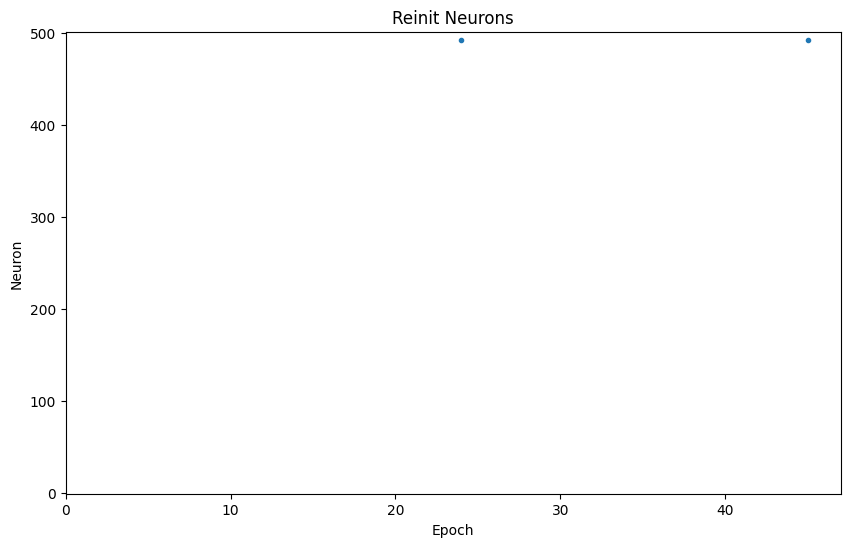

In [287]:
output_utility , age, NumOfUnitsToReplace, UpdateNeuron = reinitNeurons(rateOutput, output_utility , age, NumOfUnitsToReplace, settings)
Reinit_History.append(UpdateNeuron)
epoch +=1
print("Epoch", epoch)
print(Reinit_History)
print("NumOfUnitsToReplace",NumOfUnitsToReplace)
#print("age",age)
plotReinit(epoch,Reinit_History)

In [ ]:
writer.close()

In [1]:
EvalOutput = model0.EvalModel(settings,True,[])

NameError: name 'model0' is not defined

In [ ]:
delays = np.arange(0,50,50)

RandomDelay = False
LastCatchSuccess = 0

ParameterResetValue = 6
for delay in delays:    

    settings["Tdelay"] = delay
    DiscrimPerform = 0
    CatchPerform = 0
    BreakFlag = 0
    WhileCounter = 0
    while (DiscrimPerform <= 1 and CatchPerform < 0.95): 
        print("------------------------------------\n")
        print(f"--------Delay: {delay}-------------\n")
        print("------------------------------------\n")

        if (WhileCounter >= ParameterResetValue and delay > 0) or (CatchPerform <= 0.2 and delay > 0 and WhileCounter >= 1):
            WhileCounter = 0
            print("-----Reload Model-----")
            model0.reload_rnn_from_db(model0.db_path,LastCatchSuccess)

        EvalOutput,BreakFlag = model0.train_model(settings)
        DiscrimPerform = EvalOutput["eval_perf_discrim_mean"]
        CatchPerform = EvalOutput["eval_perf_catch_mean"]
        WhileCounter += 1
        print("WhileCounter: ", WhileCounter)
        BioActivation = ["leaky" in x for x in [model0.ppc_rate_String,model0.pul_rate_String,model0.trn_rate_String]]
        if BreakFlag == 1:
            print("--Step--") 
            break
        if BreakFlag == 2 and all(not x for x in BioActivation):
            print("-----Reload Model-----")
            model0.reload_rnn_from_db(model0.db_path,LastCatchSuccess)
            continue
    
    DiscrimPerform = 0
    CatchPerform = 0
    BioActivation = ["leaky" in x for x in [model0.ppc_rate_String,model0.pul_rate_String,model0.trn_rate_String]]    
    if all(x for x in BioActivation):
        model0.resetActivation("ALL","relu")
        model0.resetActivation("TRN","alpha_relu")
        while (DiscrimPerform <= 1 and CatchPerform < 0.95): 
            print("------------------------------------\n")
            print(f"--------relu: Transfer-------------\n")
            print("------------------------------------\n")




            EvalOutput,BreakFlag = model0.train_model(settings)
            DiscrimPerform = EvalOutput["eval_perf_discrim_mean"]
            CatchPerform = EvalOutput["eval_perf_catch_mean"]
            if BreakFlag:
                break
    
    LastCatchSuccess = model0.get_last_index(model0.db_path, "id")

if RandomDelay == True:
    settings["Delay_Type"] = "Random"
    DiscrimPerform = 0
    CatchPerform = 0
    BreakFlag = 0
    WhileCounter = 0
    while (DiscrimPerform <= 1 and CatchPerform < 0.95): 
        print("------------------------------------\n")
        print(f"--------Delay Type: Random-------------\n")
        print("------------------------------------\n")
        EvalOutput,BreakFlag = model0.train_model(settings)
        DiscrimPerform = EvalOutput["eval_perf_discrim_mean"]
        CatchPerform = EvalOutput["eval_perf_catch_mean"]
        WhileCounter += 1
        if (WhileCounter >= ParameterResetValue) or (CatchPerform <= 0.2 and WhileCounter >= 1):
            WhileCounter = 0
            print("-----Reload Model-----")
            model0.reload_rnn_from_db(model0.db_path,LastCatchSuccess)

        if BreakFlag == 1:
            break





In [ ]:
EvalOutput = model0.EvalModel(settings,True,[])

In [ ]:
batch_size = 2
Neurons = 500
Channels = 10

Wn = torch.ones((Neurons, Channels), device="cpu") * 2         # (N, C)
In = torch.randn((batch_size, Channels, 1), device="cpu")      # (B, C, k)

# Use 'n' for neurons, 'c' for channels, 'b' for batch, and 'k' for the dummy last dim
Wo = torch.einsum("nc,bck->bnk", Wn, In)  # Result: (B, N, 1)

print(Wo.shape)  # torch.Size([2, 500, 1])

In [ ]:
settings["Delay_Type"] = "Fixed"
EvalOutput = model0.EvalModel(settings,True,[])

In [ ]:
db_path = r'c:\\Users\\distr\\NeuralModels\\RNNmodelDB\\Experiments\\RateRNNstructNUM39.db'
model0.load_rnn_from_db(db_path)
settings["Delay_Type"] = "Random"
settings["SampleTest"] = "Select"

TotalPerform =list()
DiscrimPerform =list()
CatchPerform =list()
CatchLeftPerform =list()
CatchRightPerform =list()

settings["ProbArrayInput"] = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for i in range(0,10):
    EvalOutput = model0.EvalModel(settings,True)
    TotalPerform.extend([EvalOutput["eval_perf_mean"]])
    DiscrimPerform.extend([EvalOutput["eval_perf_discrim_mean"]])
    CatchPerform.extend([EvalOutput["eval_perf_catch_mean"]])
    CatchLeftPerform.extend([EvalOutput["eval_perf_catch_right_mean"]])
    CatchRightPerform.extend([EvalOutput["eval_perf_catch_left_mean"]])
    
MeanTotalPerform = np.mean(TotalPerform); print("Mean Total Perform: ", MeanTotalPerform)
MeanDiscrimPerform = np.mean(DiscrimPerform); print("Mean Discrim Perform: ", MeanDiscrimPerform)
MeanCatchPerform = np.mean(CatchPerform); print("Mean Catch Perform: ", MeanCatchPerform)
MeanCatchLeftPerform = np.mean(CatchLeftPerform); print("Mean Catch Left Perform: ", MeanCatchLeftPerform)
MeanCatchRightPerform = np.mean(CatchRightPerform); print("Mean Catch Right Perform: ", MeanCatchRightPerform)

In [ ]:
np.linspace(0,40000,101)



In [ ]:



delays = [1600, 2200, 2800, 3400, 4000]

#delays = [9000, 10000,12000,14000,16000]

for d in delays:
    print(f"=========Delay{d}==========")
    settings["Tdelay"] = d
    settings["Delay_Type"] = "Fixed"
    settings["SampleTest"] = "Pure"
    settings["GPU_Eval_Blocks"] = 10
    settings["BlockMultiplier"] =  50

    EvalOutput = model0.EvalModel(settings,True)

    print("Total Perform: ", EvalOutput["eval_perf_mean"])
    print("Mean Discrim Perform: ", EvalOutput["eval_perf_discrim_mean"])
    print("Mean Catch Perform: ", EvalOutput["eval_perf_catch_mean"])
    print("Mean Catch Left Perform: ", EvalOutput["eval_perf_catch_right_mean"])
    print("Mean Catch Right Perform: ", EvalOutput["eval_perf_catch_left_mean"])

In [ ]:
25*20

In [ ]:
settings["Manipulation"] = "SuppressNeurons"
settings["SampleTest"] = "Pure"
settings["DelaySuppressOn"] = True
settings["SuppressLength"] = 100
settings["Delay_Type"] = "Random"
settings["Tdelay"] = 200

NeuronsSuppressed = model0.PPCIdx
NeuronsSuppressed = model0.PPCIdx_Exh
NeuronsSuppressed = model0.PPCIdx_Inh

NeuronsSuppressed = model0.PulIdx_Exh
NeuronsSuppressed = model0.TrnIdx_Inh
NeuronsSuppressed = []

#print(type(model0.PulIdx_Exh.tolist()))


#SynapseSuppressed = list()

#SynapseSuppressed.append(model0.PulIdx_Exh.tolist())
#SynapseSuppressed.append( model0.TrnIdx_Inh.tolist())
#print(SynapseSuppressed)
EvalOutput = model0.EvalModel( settings, True, opto_idx=NeuronsSuppressed, PrintResult=True)

In [ ]:
plt.figure(figsize=(14, 10))  # Width = 10 inches, Height = 6 inches
GpuBlock = 1
Block = 1
plt.plot(EvalOutput["uEvals"][GpuBlock][Block])
plt.plot(EvalOutput["zEvals"][GpuBlock][Block])
plt.plot(EvalOutput["oEvals"][GpuBlock][Block])
plt.legend(["Stim","Target","Rnn Output"])
plt.axhline(y=0.75, color='grey', linestyle='--')  # Horizontal line at y=10
plt.axhline(y=-0.75, color='grey', linestyle='--')  # Horizontal line at y=20

In [ ]:
Wr = model0.Wr
PPCIdx = model0.PPCIdx
PPCIdx_Exh = model0.PPCIdx_Exh
PPCIdx_Inh = model0.PPCIdx_Inh



PulIdx_Exh = model0.PulIdx_Exh
TrnIdx_Inh = model0.TrnIdx_Inh

Gt0_01 = list()
Gt0_1 = list()
Gt0_2 = list()
Wippc2pul = torch.tensor([])
for ePpcIdx in PPCIdx_Exh:

    Wtemp = Wr[PulIdx_Exh, ePpcIdx].detach().cpu()
    Gt0_01.append( Wtemp > 0.01)
    Gt0_1.append( Wtemp > 0.1)
    Gt0_2.append( Wtemp > 0.2)



In [ ]:
#db_path = r"C:\Users\distr\NeuralModels\RNNmodelDB\Experiments\RateRNNstruct3v7NZwN1NUM13.db"
#db_path = r"C:\Users\distr\NeuralModels\RNNmodelDB\Experiments\RateRNNstructYsFy6j2HNUM16.db"
#db_path = r"C:\Users\distr\NeuralModels\RNNmodelDB\Experiments\RateRNNstructvRLQDz5BNUM19.db"
db_path = r"C:\\Users\\distr\\NeuralModels\\RNNmodelDB\\Experiments\\RateRNNstructomM3Z2ueNUM25.db"
model0.load_rnn_from_db(db_path)

In [ ]:
Wr = model0.Wr
SynapseMask = model0.SynapseMask


WrDale = torch.relu(Wr)
WrReal = torch.mul( WrDale, SynapseMask);

PPCIdx = model0.PPCIdx
PPCIdx_Exh = model0.PPCIdx_Exh
PPCIdx_Inh = model0.PPCIdx_Inh

PulIdx_Exh = model0.PulIdx_Exh
TrnIdx_Inh = model0.TrnIdx_Inh


print("PPC Connections")

PPCInh2PUL = torch.tensor([])
for i in range(0,len(PPCIdx_Inh)):
    Wtemp = WrReal[PulIdx_Exh,PPCIdx_Inh[i]].detach().cpu()
    PPCInh2PUL = torch.concatenate( (PPCInh2PUL, Wtemp) )

PPCExh2PUL = torch.tensor([])
for i in range(0,len(PPCIdx_Exh)):
    Wtemp = WrReal[PulIdx_Exh,PPCIdx_Exh[i]].detach().cpu()
    PPCExh2PUL = torch.concatenate( (PPCExh2PUL, Wtemp) )

PPC2PPC = torch.tensor([])
for i in range(0,len(PPCIdx)):
    Wtemp = WrReal[PPCIdx,PPCIdx[i]].detach().cpu()
    PPC2PPC  = torch.concatenate( (PPC2PPC, Wtemp) )

PPCExh2PPCInh = torch.tensor([])
for i in range(0,len(PPCIdx_Exh)):
    Wtemp = WrReal[PPCIdx_Inh,PPCIdx_Exh[i]].detach().cpu()
    PPCExh2PPCInh  = torch.concatenate( (PPCExh2PPCInh, Wtemp) )

PPCInh2PPCExh = torch.tensor([])
for i in range(0,len(PPCIdx_Inh)):
    Wtemp = WrReal[PPCIdx_Exh,PPCIdx_Inh[i]].detach().cpu()
    PPCInh2PPCExh   = torch.concatenate( (PPCInh2PPCExh , Wtemp) )

PPCExh2PPCExh = torch.tensor([])
for i in range(0,len(PPCIdx_Exh)):
    Wtemp = WrReal[PPCIdx_Exh,PPCIdx_Exh[i]].detach().cpu()
    PPCExh2PPCExh  = torch.concatenate( (PPCExh2PPCExh, Wtemp) )

PPCInh2PPCInh = torch.tensor([])
for i in range(0,len(PPCIdx_Inh)):
    Wtemp = WrReal[PPCIdx_Inh,PPCIdx_Inh[i]].detach().cpu()
    PPCInh2PPCInh  = torch.concatenate( (PPCInh2PPCInh, Wtemp) )

PPCdata = [PPC2PPC ,PPCExh2PPCExh,PPCInh2PPCInh,PPCExh2PPCInh,PPCInh2PPCExh,PPCInh2PUL,PPCExh2PUL]


In [ ]:
# Create subplots
fig, axes = plt.subplots(len(PPCdata), 1, figsize=(8, 12), constrained_layout=True)

# Determine the global min and max for the x-axis range
flattened_PPCdata = torch.cat(PPCdata)
global_min = min(flattened_PPCdata )
global_max = max(flattened_PPCdata )

PPCdataNames = ["PPC -> PPC" ,"PPCExh -> PPCExh","PPCInh -> PPCInh","PPCExh -> PPCInh","PPCInh -> PPCExh","PPCInh -> PUL","PPCExh -> PUL"]
# Plot each histogram
for i, ax in enumerate(axes):
    ax.hist(PPCdata[i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f"Histogram {i+1}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xlim(global_min, global_max)  # Set the same x-axis for all histograms
    ax.set_title(PPCdataNames[i])


# Show the plots
plt.show()

In [ ]:
Wr = model0.Wr
SynapseMask = model0.SynapseMask


WrDale = torch.relu(Wr)
WrReal = torch.mul( WrDale, SynapseMask);

PPCIdx = model0.PPCIdx
PPCIdx_Exh = model0.PPCIdx_Exh
PPCIdx_Inh = model0.PPCIdx_Inh

PulIdx = model0.PulIdx_Exh
TrnIdx = model0.TrnIdx_Inh


print("PPC Connections")

PPC2PPC = torch.tensor([])
for i in range(0,len(PPCIdx)):
    Wtemp = SynapseMask[PPCIdx,PPCIdx[i]].detach().cpu()
    PPC2PPC  = torch.concatenate( (PPC2PPC, Wtemp) )

PPCExh2PPCExh = torch.tensor([])
for i in range(0,len(PPCIdx_Exh)):
    Wtemp = SynapseMask[PPCIdx_Exh,PPCIdx_Exh[i]].detach().cpu()
    PPCExh2PPCExh  = torch.concatenate( (PPCExh2PPCExh, Wtemp) )

PPCInh2PPCInh = torch.tensor([])
for i in range(0,len(PPCIdx_Inh)):
    Wtemp = SynapseMask[PPCIdx_Inh,PPCIdx_Inh[i]].detach().cpu()
    PPCInh2PPCInh  = torch.concatenate( (PPCInh2PPCInh, Wtemp) )

PPCExh2PPCInh = torch.tensor([])
for i in range(0,len(PPCIdx_Exh)):
    Wtemp = SynapseMask[PPCIdx_Inh,PPCIdx_Exh[i]].detach().cpu()
    PPCExh2PPCInh  = torch.concatenate( (PPCExh2PPCInh, Wtemp) )

PPCInh2PPCExh = torch.tensor([])
for i in range(0,len(PPCIdx_Inh)):
    Wtemp = SynapseMask[PPCIdx_Exh,PPCIdx_Inh[i]].detach().cpu()
    PPCInh2PPCExh   = torch.concatenate( (PPCInh2PPCExh , Wtemp) )



PPCInh2PUL = torch.tensor([])
for i in range(0,len(PPCIdx_Inh)):
    Wtemp = SynapseMask[PulIdx,PPCIdx_Inh[i]].detach().cpu()
    PPCInh2PUL = torch.concatenate( (PPCInh2PUL, Wtemp) )

PPCExh2PUL = torch.tensor([])
for i in range(0,len(PPCIdx_Exh)):
    Wtemp = SynapseMask[PulIdx,PPCIdx_Exh[i]].detach().cpu()
    PPCExh2PUL = torch.concatenate( (PPCExh2PUL, Wtemp) )






PPCdata = [PPC2PPC ,PPCExh2PPCExh,PPCInh2PPCInh,PPCExh2PPCInh,PPCInh2PPCExh,PPCInh2PUL,PPCExh2PUL]


In [ ]:
# Create subplots
fig, axes = plt.subplots(len(PPCdata), 1, figsize=(8, 12), constrained_layout=True)

# Determine the global min and max for the x-axis range
flattened_PPCdata = torch.cat(PPCdata)
global_min = min(flattened_PPCdata )
global_max = max(flattened_PPCdata )

PPCdataNames = ["PPC -> PPC" ,"PPCExh -> PPCExh","PPCInh -> PPCInh","PPCExh -> PPCInh","PPCInh -> PPCExh","PPCInh -> PUL","PPCExh -> PUL"]
# Plot each histogram
for i, ax in enumerate(axes):
    ax.hist(PPCdata[i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f"Histogram {i+1}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xlim(global_min, global_max)  # Set the same x-axis for all histograms
    ax.set_title(PPCdataNames[i])


# Show the plots
plt.show()

In [ ]:
Wr = model0.Wr
PPCIdx = model0.PPCIdx
PPCIdx_Exh = model0.PPCIdx_Exh
PPCIdx_Inh = model0.PPCIdx_Inh

PulIdx_Exh = model0.PulIdx_Exh
TrnIdx_Inh = model0.TrnIdx_Inh

Wippc2pul = torch.tensor([])
for iPpcIdx in PPCIdx_Inh:

    Wtemp = Wr[PulIdx_Exh, iPpcIdx].detach().cpu()
    
    Wippc2pul = torch.concatenate([Wippc2pul,Wtemp])

filtered_Wippc2pul = Wippc2pul[Wippc2pul != 0]
#plt.hist(Wippc2pul,bins=50);
plt.hist(filtered_Wippc2pul,bins=50);
plt.title("PPC Inh to PUL")

Weppc2pul = torch.tensor([])
for ePpcIdx in PPCIdx_Exh:

    Wtemp = Wr[PulIdx_Exh, ePpcIdx].detach().cpu()
    
    Weppc2pul = torch.concatenate([Weppc2pul,Wtemp])
plt.figure()
filtered_Weppc2pul = Weppc2pul[Weppc2pul != 0]
#plt.hist(Weppc2pul,bins=50);
plt.hist(filtered_Weppc2pul,bins=50);
plt.title("PPC Exh to PUL");

In [ ]:


SuppressLength = 100
DelayLength = 100

#if settings["DelaySuppressOn"] == True:
#    assert SuppressLength < DelayLength, "Suppress Length is less than Delay Length"


N = model0.N
DelayMax = torch.max(EvalOutput["DelayStartEval"][0]).tolist()
print(DelayMax)

optoMask_Time = torch.ones(N,N,DelayMax)

# Calculate memory usage in bytes
memory_bytes = optoMask_Time.numel() * optoMask_Time.element_size()

# Convert to kilobytes, megabytes, etc.
memory_mb = memory_bytes  / 2**20     # Megabytes
print(f"Memory usage: {memory_mb:.2f} MB")


for di in range(0,EvalOutput["DelayStartEval"][0].size(1) ):
    Didx = EvalOutput["DelayStartEval"][0][:,di] -1
    print(Didx)
    for i in range(0,len(Didx)):
        print(Didx[i])
        optoMask_Time[:,:,Didx[i]:SuppressLength ] = 0

optoMask_Time[:,:,200]

In [ ]:
Wr =  model0.Wr.detach().cpu().numpy() 

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(Wr)

# Plot the eigenvalues on a semilogarithmic scale
plt.figure()
plt.semilogy(np.abs(eigenvalues), 'o')  # Use absolute values to avoid issues with negative eigenvalues
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Eigenvalues of Wr on Semilogarithmic Scale")
plt.grid(True)
plt.show()

In [ ]:
# Sample data
data =  model0.Wr.detach().cpu().numpy().flatten()  # 1000 random values
print(max(data))
# Sort the data
sorted_data = np.sort(data)

# Calculate the cumulative distribution (y-values range from 0 to 1)
cumulative_distribution = np.linspace(0, 1, len(sorted_data))

# Plot the cumulative distribution
plt.plot(sorted_data, cumulative_distribution, label='CDF')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Random Values')
plt.legend()

# Display the plot
plt.show()

plt.hist(data,bins=100);

In [ ]:
import torch
import numpy as np
import scipy.io

# Assuming these are the model attributes you want to save
Wr = model0.Wr.detach().cpu().numpy()  # Convert to NumPy
SynapseMask = model0.SynapseMask.detach().cpu().numpy()
Wout = model0.Wout.detach().cpu().numpy()
tauS = model0.tauS.detach().cpu().numpy()
b_out = model0.b_out.detach().cpu().numpy()
N = model0.N  # N is already a scalar, no need for conversion

# Create a dictionary to store these variables
mat_dict = {
    'Wr': Wr,
    'SynapseMask': SynapseMask,
    'Wout': Wout,
    'tauS': tauS,
    'b_out': b_out,
    'N': N
}

# Save the dictionary to a .mat file
scipy.io.savemat('model_parameters_2.mat', mat_dict)

print("Model parameters saved to model_parameters.mat")


### One Second Delay